In [ ]:
#   This software component is licensed by ST under BSD-3-Clause license,
#   the "License"; You may not use this file except in compliance with the
#   License. You may obtain a copy of the License at:
#             https://opensource.org/licenses/BSD-3-Clause

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/STMicroelectronics/stm32ai/blob/master/AI_resources/AI_resources/VISION/transfer_learning/TransferLearning.ipynb)

# Transfer Learning on MobileNet

This notebook shows the process of training a deep learning model via transfer learning on a custom dataset as well as the quantization of this model to in order to use it on a STM32 thanks to [STM32Cube.AI](https://www.st.com/en/embedded-software/x-cube-ai.html).

## Import the dataset

The dataset is a directory containing one sub-directory per category, with images inside. For instance: 
```
Dataset
    ├── cats
    │   ├── cat0001.jpg
    │   ├── cat0002.jpg
    │   └── ...
    ├── dogs
    └── horses
```
If you're using this in notebook in Colab, you should import your dataset a `Dataset.zip` file. It will be extracted later on. Also on Colab, make sure you choose the GPU runtime for faster training.

## Import necessary packages

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

## Unzip and load the dataset

Shuffle the data, and resize images to 128x128 pixels

In [ ]:
!unzip -q Dataset.zip

In [ ]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 16
dataset = image_dataset_from_directory('Dataset',
          shuffle=True,
          batch_size=BATCH_SIZE,
          image_size=IMG_SIZE, 
          interpolation='nearest',
          label_mode='categorical' # yields "one-hot" vectors for output
          )


Found 1408 files belonging to 8 classes.


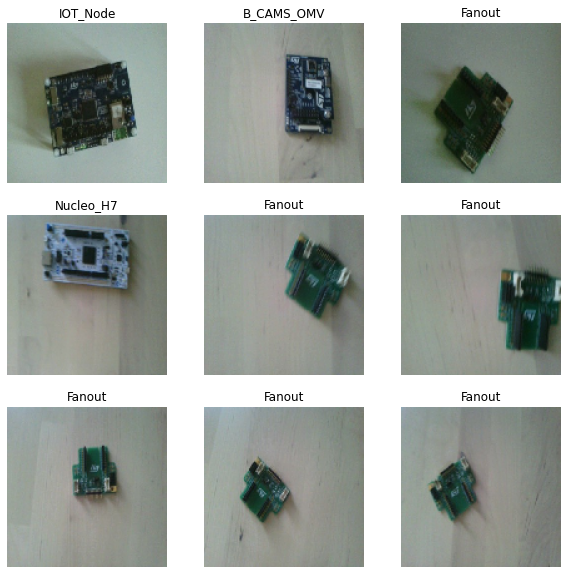

In [ ]:
class_names = dataset.class_names
class_number = len(class_names)

plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.argmax(labels[i]) ]) 
    plt.axis("off")

## Split the data between train/validation 

In [ ]:
nbr_batches = tf.data.experimental.cardinality(dataset)

# We take 20% for validation
validation_dataset = dataset.take(nbr_batches // 5)
train_dataset = dataset.skip(nbr_batches // 5)

## Augment the data for training set

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.4),
  tf.keras.layers.experimental.preprocessing.RandomTranslation(0.1, 0.1),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

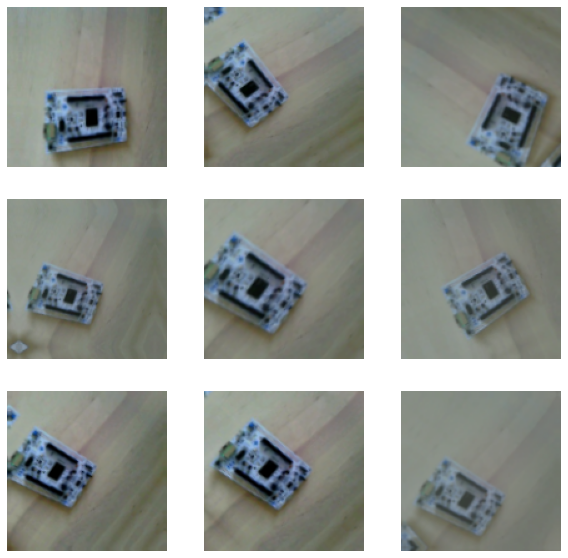

In [ ]:
# Run this cell several times to see the effect on different data
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
# Apply data augmentation to training set
train_dataset = train_dataset.map(lambda image, label: (data_augmentation(image, training=True), label), 
                num_parallel_calls=tf.data.AUTOTUNE)

## Normalize the data before training

In [ ]:
# Add the normalization layer 
normalization = tf.keras.applications.mobilenet.preprocess_input

train_dataset = train_dataset.map(lambda img, label: (normalization(tf.cast(img, tf.float32)), label), num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(lambda img, label: (normalization(tf.cast(img, tf.float32)), label), num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Create the model

We start from a pretrained MobileNet V1

In [ ]:
# Create the base model from the pre-trained model MobileNet V1
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                             alpha=0.25,
                                             include_top=False,
                                             weights='imagenet')

base_model.trainable = False

2113536/2108140 [==============================] - 0s 0us/step


In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
mobilenet_0.25_128 (Function (None, 4, 4, 256)         218544    
_________________________________________________________________
global_average_pooling2d (Gl (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 2056      
Total params: 220,600
Trainable params: 2,056
Non-trainable params: 218,544
_________________________________________________________________


In [ ]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

## Train the model

In [ ]:
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=validation_dataset)

Epoch 1/20
71/71 [==============================] - 13s 79ms/step - loss: 2.2250 - accuracy: 0.2306 - val_loss: 1.0508 - val_accuracy: 0.6691
Epoch 2/20
71/71 [==============================] - 6s 74ms/step - loss: 1.0831 - accuracy: 0.6388 - val_loss: 0.6360 - val_accuracy: 0.8493
Epoch 3/20
71/71 [==============================] - 6s 74ms/step - loss: 0.7164 - accuracy: 0.7819 - val_loss: 0.5081 - val_accuracy: 0.8640
Epoch 4/20
71/71 [==============================] - 6s 74ms/step - loss: 0.5448 - accuracy: 0.8524 - val_loss: 0.3951 - val_accuracy: 0.9081
Epoch 5/20
71/71 [==============================] - 6s 74ms/step - loss: 0.4641 - accuracy: 0.8687 - val_loss: 0.3179 - val_accuracy: 0.9228
Epoch 6/20
71/71 [==============================] - 6s 74ms/step - loss: 0.3705 - accuracy: 0.9035 - val_loss: 0.2845 - val_accuracy: 0.9412
Epoch 7/20
71/71 [==============================] - 6s 75ms/step - loss: 0.3056 - accuracy: 0.9137 - val_loss: 0.2513 - val_accuracy: 0.9375
Epoch 8/20
7

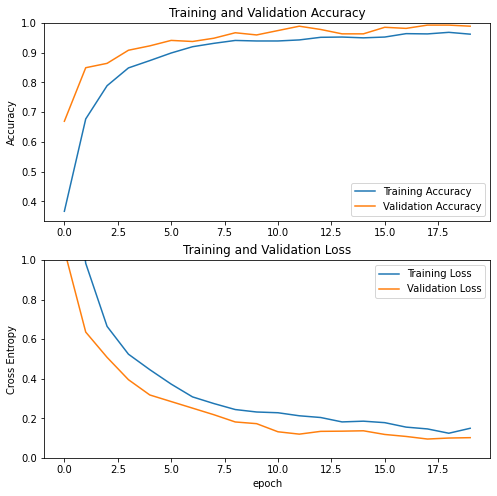

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Quantize and export 

This cell will quantize the model and output a `model_quant.tflite` file that you can use with Cube.AI 

In [ ]:
def representative_data_gen():
  for x, y in validation_dataset.take(100):
    yield [x]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

import pathlib
tflite_model_quant = converter.convert()
tflite_model_quant_file = pathlib.Path("./model_quant.tflite")
tflite_model_quant_file.write_bytes(tflite_model_quant)

INFO:tensorflow:Assets written to: /tmp/tmp_272ro6m/assets


331952